In [283]:
import pandas as pd
import numpy as np

import mplfinance as mpf
import matplotlib.pyplot as plot

from alpha_vantage.timeseries import TimeSeries

In [284]:
stock_name = 'NVDA'

### import data alpha vantage

In [285]:
api_key = '88077VO3V57JW1I3'
ts = TimeSeries(key = api_key, output_format = 'pandas')
data_alpha, metadata = ts.get_daily_adjusted(symbol= stock_name, outputsize='full')

In [286]:
data_alpha = data_alpha.drop(['7. dividend amount', '8. split coefficient'], axis=1)
data_alpha = data_alpha.sort_index()
data_alpha.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

In [287]:
data_alpha

,open,high,low,close,adjclose,volume
date,,,,,,
1999-11-01,21.75,24.38,21.75,23.50,0.449305,1630300.0
1999-11-02,23.94,25.13,23.75,25.00,0.477984,1744800.0
1999-11-03,26.00,28.13,25.81,27.44,0.524635,4191000.0
1999-11-04,27.75,29.94,27.75,29.19,0.558094,2625700.0
1999-11-05,30.00,30.25,26.88,28.25,0.540122,1284100.0
...,...,...,...,...,...,...
2023-05-22,309.01,315.20,306.80,311.76,311.760000,37199967.0
2023-05-23,310.00,312.88,306.31,306.88,306.880000,35625326.0
2023-05-24,302.10,306.07,298.06,305.38,305.380000,72141851.0


### import data from yahoo finance

In [288]:
from pandas_datareader import data as web
import yfinance as yf
yf.pdr_override()

In [289]:
start = '2022-01-01'
end = '2021-12-31'
data_yh = web.get_data_yahoo(stock_name, start = start)
data_yh.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
data_yh.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adjclose,volume
Date,,,,,,
2021-12-31,296.739990,300.299988,293.309998,294.109985,293.785339,26653000
2022-01-03,298.149994,307.109985,297.850006,301.209991,300.877502,39154700
2022-01-04,302.769989,304.679993,283.489990,292.899994,292.576691,52715400
2022-01-05,289.489990,294.160004,275.329987,276.040009,275.735291,49806400
2022-01-06,276.399994,284.380005,270.649994,281.779999,281.468964,45418600


### Build function

In [290]:
def rsi_strategy(df, days = 14, lower_lim = 30, upper_lim = 70):
    change = df['close'].diff(1)
    gain = change.mask(change < 0, 0)
    loss = change.mask(change > 0, 0)
    avg_gain = gain.rolling(days).mean()
    avg_loss = abs(loss.rolling(days).mean())
    rs = avg_gain/avg_loss
    rsi = 100 - (100/(1+rs))
    df['rsi'] = rsi

    #strategy
    df.loc[df['rsi'] < lower_lim, 'action'] = 'buy'
    df.loc[df['rsi'] > upper_lim, 'action'] = 'sell'
    df.loc[df['action'] == 'buy', 'marker_position'] = df['low'] * 0.98
    df.loc[df['action'] == 'sell', 'marker_position'] = df['high'] * 1.02

    return df

In [291]:
rsi_data = rsi_strategy(data_alpha, 14, 26, 73)
rsi_data[rsi_data['action'].notnull()].head()

,open,high,low,close,adjclose,volume,rsi,action,marker_position
date,,,,,,,,,
1999-11-19,40.13,44.38,40.00,42.88,0.819838,4510800.0,90.611903,sell,45.2676
1999-11-22,43.97,44.00,40.25,42.81,0.818499,1125400.0,89.701293,sell,44.8800
1999-11-23,38.25,40.19,38.00,39.75,0.759994,1152600.0,76.702820,sell,40.9938
1999-12-30,46.00,46.69,45.25,46.38,0.886755,291200.0,73.501763,sell,47.6238
1999-12-31,46.28,47.00,46.13,46.94,0.897462,265300.0,76.254376,sell,47.9400


In [292]:
def rsi_plot(df_plot, days = 14, lower_lim = 30, upper_lim = 70):
    df = rsi_strategy(df_plot, days, lower_lim, upper_lim)

    plot_rsi = mpf.make_addplot(df['rsi'], panel = 1, color = 'blue', title = 'RSI', ylim = (0, 100))
    
    marker = ['^' if x == 'buy' else 'v' for x in df['action']]
    color_marker = ['green' if x == 'buy' else 'red' for x in df['action']]

    plot_signal = mpf.make_addplot(df['marker_position'], type = 'scatter', marker = marker, color = color_marker)
    
    plots = [plot_rsi, plot_signal]

    return plots, lower_lim, upper_lim

### Display

In [293]:
rsi_plots, lower_lim, upper_lim = rsi_plot(data_yh, lower_lim = 30, upper_lim = 70)

In [294]:
lower_lim, upper_lim

(30, 70)

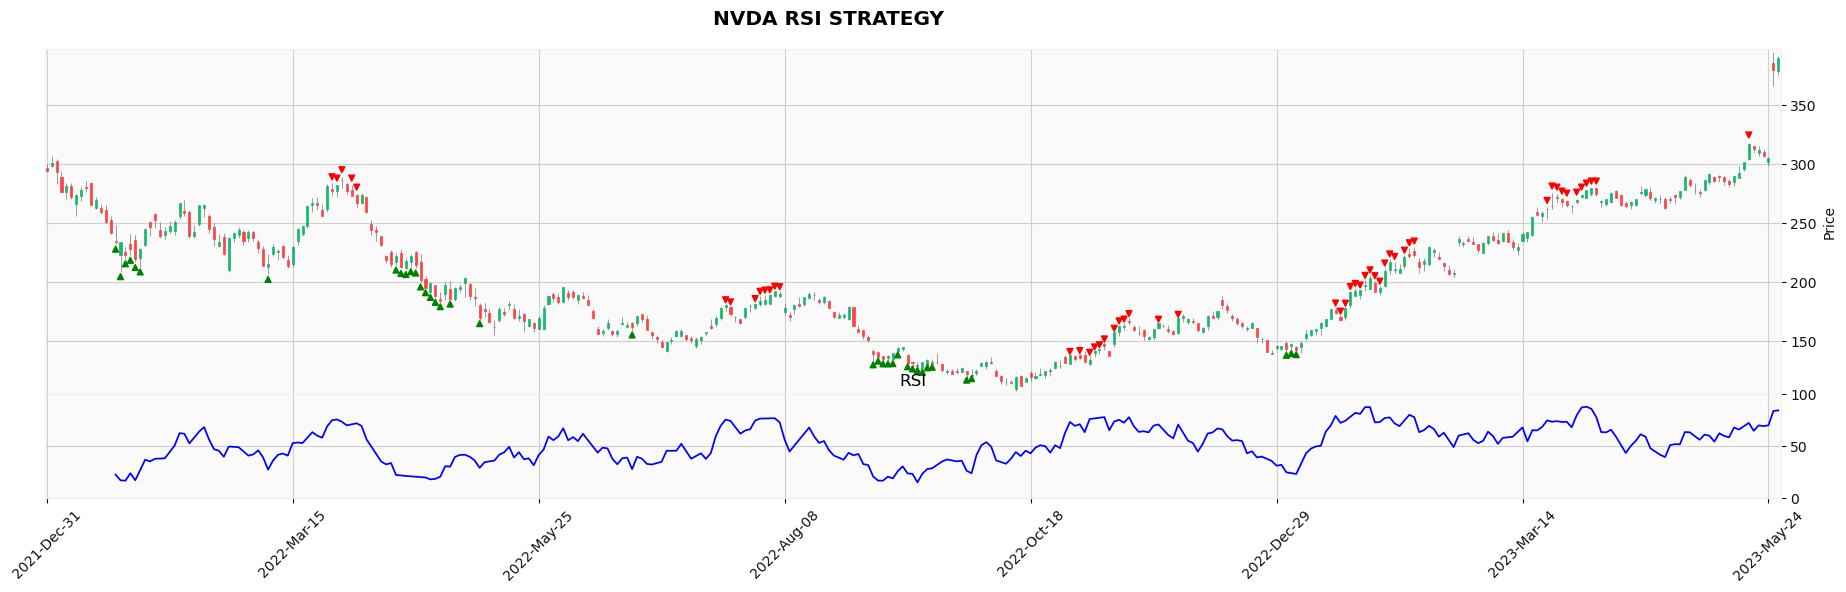

In [295]:
mpf.plot(data_yh, type = 'candle', style = 'yahoo', addplot = rsi_plots,
         title = stock_name + ' RSI STRATEGY',
         figsize = (20,6), panel_ratios = (1,0.3),
         tight_layout = True, scale_padding = {'top' : 5})

In [296]:
data_yh

,open,high,low,close,adjclose,volume,rsi,action,marker_position
Date,,,,,,,,,
2021-12-31,296.739990,300.299988,293.309998,294.109985,293.785339,26653000,NaN,NaN,NaN
2022-01-03,298.149994,307.109985,297.850006,301.209991,300.877502,39154700,NaN,NaN,NaN
2022-01-04,302.769989,304.679993,283.489990,292.899994,292.576691,52715400,NaN,NaN,NaN
2022-01-05,289.489990,294.160004,275.329987,276.040009,275.735291,49806400,NaN,NaN,NaN
2022-01-06,276.399994,284.380005,270.649994,281.779999,281.468964,45418600,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-05-22,309.010010,315.200012,306.799988,311.760010,311.760010,37200000,69.731225,NaN,NaN
2023-05-23,310.000000,312.880005,306.309998,306.880005,306.880005,35625300,68.996838,NaN,NaN
2023-05-24,302.100006,306.070007,298.059998,305.380005,305.380005,72141900,69.824132,NaN,NaN


In [297]:
copy_data = data_yh.copy()
copy_data['action_price'] = copy_data['open'].shift(-1)
copy_data.head()

,open,high,low,close,adjclose,volume,rsi,action,marker_position,action_price
Date,,,,,,,,,,
2021-12-31,296.739990,300.299988,293.309998,294.109985,293.785339,26653000,NaN,NaN,NaN,298.149994
2022-01-03,298.149994,307.109985,297.850006,301.209991,300.877502,39154700,NaN,NaN,NaN,302.769989
2022-01-04,302.769989,304.679993,283.489990,292.899994,292.576691,52715400,NaN,NaN,NaN,289.489990
2022-01-05,289.489990,294.160004,275.329987,276.040009,275.735291,49806400,NaN,NaN,NaN,276.399994
2022-01-06,276.399994,284.380005,270.649994,281.779999,281.468964,45418600,NaN,NaN,NaN,281.410004


In [298]:
record = copy_data[copy_data['action'].notnull()]
record.head()

,open,high,low,close,adjclose,volume,rsi,action,marker_position,action_price
Date,,,,,,,,,,
2022-01-21,235.070007,248.229996,232.630005,233.740005,233.481995,71895800,22.161767,buy,227.977405,223.300003
2022-01-24,223.300003,233.800003,208.880005,233.720001,233.462006,91398200,16.704486,buy,204.702405,225.460007
2022-01-25,225.460007,229.429993,220.000000,223.240005,222.993591,66461600,16.354325,buy,215.600000,232.399994
2022-01-26,232.399994,240.570007,223.000000,227.720001,227.468628,75595900,23.491323,buy,218.540000,235.679993
2022-01-27,235.679993,239.949997,216.750000,219.440002,219.197769,57335300,16.727156,buy,212.415000,220.119995


In [299]:
record['pre_action'] = record['action'].shift(1)
record

C:\Users\User\AppData\Local\Temp/ipykernel_49500/1997362869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record['pre_action'] = record['action'].shift(1)


,open,high,low,close,adjclose,volume,rsi,action,marker_position,action_price,pre_action
Date,,,,,,,,,,,
2022-01-21,235.070007,248.229996,232.630005,233.740005,233.481995,71895800,22.161767,buy,227.977405,223.300003,NaN
2022-01-24,223.300003,233.800003,208.880005,233.720001,233.462006,91398200,16.704486,buy,204.702405,225.460007,buy
2022-01-25,225.460007,229.429993,220.000000,223.240005,222.993591,66461600,16.354325,buy,215.600000,232.399994,buy
2022-01-26,232.399994,240.570007,223.000000,227.720001,227.468628,75595900,23.491323,buy,218.540000,235.679993,buy
2022-01-27,235.679993,239.949997,216.750000,219.440002,219.197769,57335300,16.727156,buy,212.415000,220.119995,buy
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-03,275.089996,280.000000,273.359985,279.649994,279.649994,39871600,85.706442,sell,285.600000,279.660004,sell
2023-04-04,279.660004,280.000000,273.070007,274.529999,274.529999,36859200,77.749104,sell,285.600000,268.290009,sell
2023-05-18,304.100006,318.279999,303.200012,316.779999,316.779999,74872500,72.135193,sell,324.645599,315.359985,sell


In [300]:
record = record.loc[record['pre_action'] != record['action']]
record

,open,high,low,close,adjclose,volume,rsi,action,marker_position,action_price,pre_action
Date,,,,,,,,,,,
2022-01-21,235.070007,248.229996,232.630005,233.740005,233.481995,71895800,22.161767,buy,227.977405,223.300003,NaN
2022-03-25,278.859985,283.579987,272.709991,276.920013,276.661469,57901600,74.719285,sell,289.251586,277.559998,buy
2022-04-13,217.279999,225.000000,214.550003,222.029999,221.822678,51694300,21.865834,buy,210.259003,225.050003,sell
2022-07-21,178.850006,181.440002,175.449997,180.500000,180.369598,55704900,75.293094,sell,185.068802,178.929993,buy
2022-09-01,142.089996,143.800003,132.699997,139.369995,139.269302,117886500,20.367617,buy,130.045997,141.000000,sell
2022-10-28,131.039993,138.500000,130.610001,138.339996,138.281128,52104000,73.021283,sell,141.270000,137.779999,buy
2023-01-03,148.509995,149.960007,140.960007,143.149994,143.125687,40127700,24.371200,buy,138.140807,145.669998,sell
2023-01-18,176.669998,178.729996,172.820007,173.770004,173.740494,43962400,78.854991,sell,182.304596,170.360001,buy


In [301]:
record['return'] = record['action_price'].pct_change()
record = record.iloc[1:]
record

C:\Users\User\AppData\Local\Temp/ipykernel_49500/393469147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record['return'] = record['action_price'].pct_change()


,open,high,low,close,adjclose,volume,rsi,action,marker_position,action_price,pre_action,return
Date,,,,,,,,,,,,
2022-03-25,278.859985,283.579987,272.709991,276.920013,276.661469,57901600,74.719285,sell,289.251586,277.559998,buy,0.242991
2022-04-13,217.279999,225.000000,214.550003,222.029999,221.822678,51694300,21.865834,buy,210.259003,225.050003,sell,-0.189184
2022-07-21,178.850006,181.440002,175.449997,180.500000,180.369598,55704900,75.293094,sell,185.068802,178.929993,buy,-0.204932
2022-09-01,142.089996,143.800003,132.699997,139.369995,139.269302,117886500,20.367617,buy,130.045997,141.000000,sell,-0.211982
2022-10-28,131.039993,138.500000,130.610001,138.339996,138.281128,52104000,73.021283,sell,141.270000,137.779999,buy,-0.022837
2023-01-03,148.509995,149.960007,140.960007,143.149994,143.125687,40127700,24.371200,buy,138.140807,145.669998,sell,0.057265
2023-01-18,176.669998,178.729996,172.820007,173.770004,173.740494,43962400,78.854991,sell,182.304596,170.360001,buy,0.169493


In [302]:
record.loc[record.loc[:,'action'] == 'buy', 'return'] = record.loc[record.loc[:,'action'] == 'buy', 'return']*(-1)

c:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [303]:
record

,open,high,low,close,adjclose,volume,rsi,action,marker_position,action_price,pre_action,return
Date,,,,,,,,,,,,
2022-03-25,278.859985,283.579987,272.709991,276.920013,276.661469,57901600,74.719285,sell,289.251586,277.559998,buy,0.242991
2022-04-13,217.279999,225.000000,214.550003,222.029999,221.822678,51694300,21.865834,buy,210.259003,225.050003,sell,0.189184
2022-07-21,178.850006,181.440002,175.449997,180.500000,180.369598,55704900,75.293094,sell,185.068802,178.929993,buy,-0.204932
2022-09-01,142.089996,143.800003,132.699997,139.369995,139.269302,117886500,20.367617,buy,130.045997,141.000000,sell,0.211982
2022-10-28,131.039993,138.500000,130.610001,138.339996,138.281128,52104000,73.021283,sell,141.270000,137.779999,buy,-0.022837
2023-01-03,148.509995,149.960007,140.960007,143.149994,143.125687,40127700,24.371200,buy,138.140807,145.669998,sell,-0.057265
2023-01-18,176.669998,178.729996,172.820007,173.770004,173.740494,43962400,78.854991,sell,182.304596,170.360001,buy,0.169493


In [304]:
record['return'].mean()

0.07551663008622612